# Evaluation Recall Analysis

One thing that the current preview experiments demonstrated (50_IP, 50_L2) it's that most of the collections evlauated in the top 50 are retrieving 0  
The goal with this notebook it's investigate possible patterns for the recurrency of this behavior  
In order to mitigate that we tried an approach where the default instruction prompt tried to incetivate the answer generation  
Here we will anlyse the following questions:
- The indexation retrieval impact in the massive lack of answers?
- The mean distance of the retrieval correlates with the lack of answer?
- The differentiation in the prompt was effective to increase the recall?

# Imports

In [1]:
import os
import random
import numpy as np
import torch

import json
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dmcr.evaluators.Rouge_L_evaluator import Rouge_L_evaluator

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
seed = 42

torch.backends.cudnn.enabled = False
# NumPy
np.random.seed(seed)
random.seed(seed)
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/caio.rhoden/miniconda3/envs/nq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of GPUs available: 1
GPU 0: NVIDIA RTX A5000


In [75]:
L2_PATH = "preview_50_L2"
IP_PATH = "preview_50_IP"
NEW_PROMPT = "new_prompt_preview_50_L2"


## The indexation retrieval impact in the massive lack of answers?

In order to this we will calculate the number of non-zero collectionss samples  
The maximun of samples of 100k for training and 20k for testing  
The setup was 4 documents in the context using Llama-3.2-8B-Instruct

**Results**:
- The IP index indicates a better recall then L2


In [15]:
## Load collections by index
train_collections = []
test_collections = []
for collection_path in [L2_PATH, IP_PATH]:
    df_train = pl.read_ipc(f"{collection_path}/datamodels/collections/train/{collection_path}_train_collection.feather").with_columns(pl.lit(f"{collection_path}").alias("collection_path"))
    df_test = pl.read_ipc(f"{collection_path}/datamodels/collections/test/{collection_path}_test_collection.feather").with_columns(pl.lit(f"{collection_path}").alias("collection_path"))
    train_collections.append(df_train)
    test_collections.append(df_test)

train_collections_df = pl.concat(train_collections)
test_collections_df = pl.concat(test_collections)

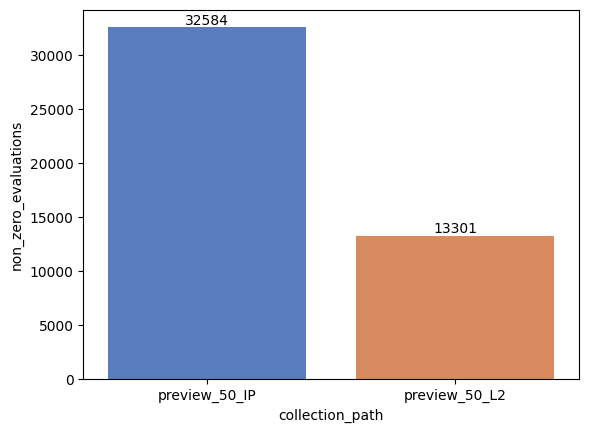

In [41]:
_temp = (
    train_collections_df
    .filter(pl.col("evaluation") > 0)
    .group_by("collection_path")
    .agg(pl.count("evaluation").alias("non_zero_evaluations"))
    .sort("collection_path")

)

ax = sns.barplot(
    data=_temp,
    x="collection_path",
    y="non_zero_evaluations",
    hue="collection_path",
    palette="muted",
    estimator=max
)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

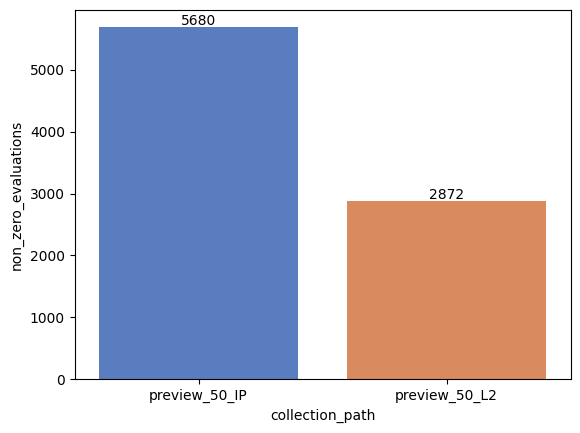

In [42]:
_temp = (
    test_collections_df
    .filter(pl.col("evaluation") > 0)
    .group_by("collection_path")
    .agg(pl.count("evaluation").alias("non_zero_evaluations"))
    .sort("collection_path")

)

ax = sns.barplot(
    data=_temp,
    x="collection_path",
    y="non_zero_evaluations",
    hue="collection_path",
    palette="muted",
    estimator=max
)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

## Does the mean distance of the retrieval correlates with the lack of answer?

In order to verify this we will caluclate the Spearman rank correlation between the distances and evaluation for each index.  
First we will do this with all samples and after that only with the evaluation-positive ones  
The setup was 4 documents in the context using Llama-3.2-8B-Instruct

In [66]:
from scipy.stats import spearmanr


In [64]:
## Load collections by index
_train_collections = []
_test_collections = []
for collection_path in [L2_PATH, IP_PATH]:
    ## Load collections
    df_train = pl.read_ipc(f"{collection_path}/datamodels/collections/train/{collection_path}_train_collection.feather").with_columns(pl.lit(f"{collection_path}").alias("collection_path"))
    df_test = pl.read_ipc(f"{collection_path}/datamodels/collections/test/{collection_path}_test_collection.feather").with_columns(pl.lit(f"{collection_path}").alias("collection_path"))
    
    ## Calculate mean distances
    distances = json.load(open(f"{collection_path}/retrieval/rag_retrieval_distances.json"))

    dict_df =  pl.DataFrame(
        {
            "test_idx": [i for i in range(50)],
            "data_array": np.array([distances[str(i)] for i in range(50)])
        }
    )

    df_train = df_train.join(dict_df, on="test_idx")
    df_test = df_test.join(dict_df, on="test_idx")

    df_train = df_train.with_columns(
        pl.sum_horizontal(
            [pl.col("input").arr.get(i) * pl.col("data_array").arr.get(i) for i in range(100)]
        ).alias("sum")
    ).with_columns(
        (pl.col("sum") / 4).alias("mean_distance")
    ).select(["test_idx", "input", "mean_distance", "collection_path", "evaluation"])


    df_test = df_test.with_columns(
        pl.sum_horizontal(
            [pl.col("input").arr.get(i) * pl.col("data_array").arr.get(i) for i in range(100)]
        ).alias("sum")
    ).with_columns(
        (pl.col("sum") / 4).alias("mean_distance")
    ).select(["test_idx", "input", "mean_distance", "collection_path", "evaluation"])


    ## Append dataframe
    _train_collections.append(df_train)
    _test_collections.append(df_test)

train_distances_df = pl.concat(_train_collections)
test_distances_df = pl.concat(_test_collections)

In [67]:
train_distances_df.head()

test_idx,input,mean_distance,collection_path,evaluation
i64,"array[i64, 100]",f64,str,f64
0,"[0, 0, … 0]",341.70359,"""preview_50_L2""",0.0
1,"[0, 0, … 0]",341.625465,"""preview_50_L2""",0.0
2,"[0, 0, … 0]",341.5047,"""preview_50_L2""",0.0
3,"[0, 0, … 0]",340.672874,"""preview_50_L2""",0.0
4,"[0, 0, … 0]",340.169632,"""preview_50_L2""",0.0


In [73]:
## Calculate correlations
for path_collection in [L2_PATH, IP_PATH]:
    _df = train_distances_df.filter(pl.col("collection_path") == path_collection)
    _dist = _df["mean_distance"].to_numpy().flatten()
    _eval = _df["evaluation"].to_numpy().flatten()
    _rho, _pvalue = spearmanr(_dist, _eval)
    print(f"Train Correlation for {path_collection}: {_rho}, p-value: {_pvalue}")

## Calculate correlations
for path_collection in [L2_PATH, IP_PATH]:
    _df = test_distances_df.filter(pl.col("collection_path") == path_collection)
    _dist = _df["mean_distance"].to_numpy().flatten()
    _eval = _df["evaluation"].to_numpy().flatten()
    _rho, _pvalue = spearmanr(_dist, _eval)
    print(f"Test Correlation for {path_collection}: {_rho}, p-value: {_pvalue}")
    

Train Correlation for preview_50_L2: -0.03580755275482231, p-value: 9.663597707422668e-30
Train Correlation for preview_50_IP: 0.3282543247130186, p-value: 0.0
Test Correlation for preview_50_L2: -0.050783019986360936, p-value: 6.672133742982587e-13
Test Correlation for preview_50_IP: 0.2510387269867, p-value: 4.795196993003845e-285


In [74]:
## Calculate correlations
for path_collection in [L2_PATH, IP_PATH]:
    _df = train_distances_df.filter(pl.col("collection_path") == path_collection).filter(pl.col("evaluation")>0)
    _dist = _df["mean_distance"].to_numpy().flatten()
    _eval = _df["evaluation"].to_numpy().flatten()
    _rho, _pvalue = spearmanr(_dist, _eval)
    print(f"Train Correlation for {path_collection}: {_rho}, p-value: {_pvalue}")

## Calculate correlations
for path_collection in [L2_PATH, IP_PATH]:
    _df = test_distances_df.filter(pl.col("collection_path") == path_collection).filter(pl.col("evaluation")>0)
    _dist = _df["mean_distance"].to_numpy().flatten()
    _eval = _df["evaluation"].to_numpy().flatten()
    _rho, _pvalue = spearmanr(_dist, _eval)
    print(f"Test Correlation for {path_collection}: {_rho}, p-value: {_pvalue}")

Train Correlation for preview_50_L2: -0.03648835249791773, p-value: 2.5626923343743842e-05
Train Correlation for preview_50_IP: 0.13851278019406416, p-value: 2.7733809130692925e-139
Test Correlation for preview_50_L2: -0.18007299006768127, p-value: 2.3428414116349033e-22
Test Correlation for preview_50_IP: 0.0795695138567824, p-value: 1.9130730642084967e-09


## The differentiation in the prompt was effective to increase the recall?

In [77]:
## Load collections by index
train_collections = []
test_collections = []
for collection_path in [L2_PATH, NEW_PROMPT]:
    df_train = pl.read_ipc(f"{collection_path}/datamodels/collections/train/{collection_path}_train_collection.feather").with_columns(pl.lit(f"{collection_path}").alias("collection_path"))
    df_test = pl.read_ipc(f"{collection_path}/datamodels/collections/test/{collection_path}_test_collection.feather").with_columns(pl.lit(f"{collection_path}").alias("collection_path"))
    train_collections.append(df_train)
    test_collections.append(df_test)

train_collections_df = pl.concat(train_collections)
test_collections_df = pl.concat(test_collections)

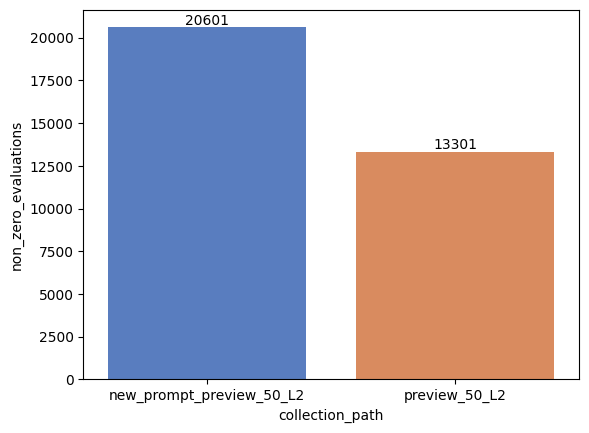

In [78]:
_temp = (
    train_collections_df
    .filter(pl.col("evaluation") > 0)
    .group_by("collection_path")
    .agg(pl.count("evaluation").alias("non_zero_evaluations"))
    .sort("collection_path")

)

ax = sns.barplot(
    data=_temp,
    x="collection_path",
    y="non_zero_evaluations",
    hue="collection_path",
    palette="muted",
    estimator=max
)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

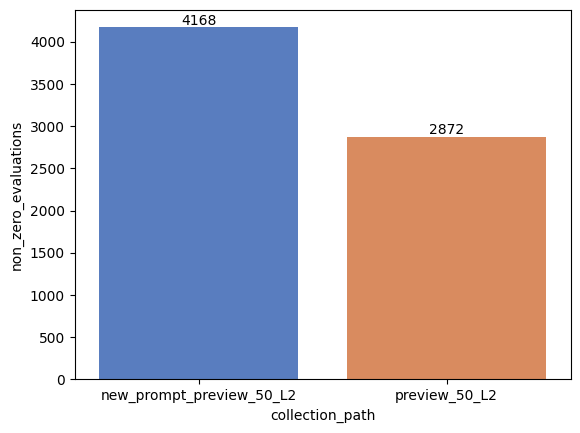

In [79]:
_temp = (
    test_collections_df
    .filter(pl.col("evaluation") > 0)
    .group_by("collection_path")
    .agg(pl.count("evaluation").alias("non_zero_evaluations"))
    .sort("collection_path")

)

ax = sns.barplot(
    data=_temp,
    x="collection_path",
    y="non_zero_evaluations",
    hue="collection_path",
    palette="muted",
    estimator=max
)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()